In [20]:
import numpy as np
import pandas as pd
from math import sqrt
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from pygam import LinearGAM, s, f
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from itertools import product

# Read and plot the data

In [21]:
#read the file
file_path = 'Data/exchange.csv'
df_exchange = pd.read_csv(file_path)

In [22]:
#filter to bitcoin-usd
df_bitcoin = df_exchange[df_exchange['currency'] == 'BTC-USD']
df_bitcoin = df_bitcoin.reset_index(drop=True)
df_bitcoin['date'] = pd.to_datetime(df_bitcoin['date'])
df_bitcoin.head()

,date,data,currency
0,2014-09-17,457.334015,BTC-USD
1,2014-09-18,424.440002,BTC-USD
2,2014-09-19,394.795990,BTC-USD
3,2014-09-20,408.903992,BTC-USD
4,2014-09-21,398.821014,BTC-USD


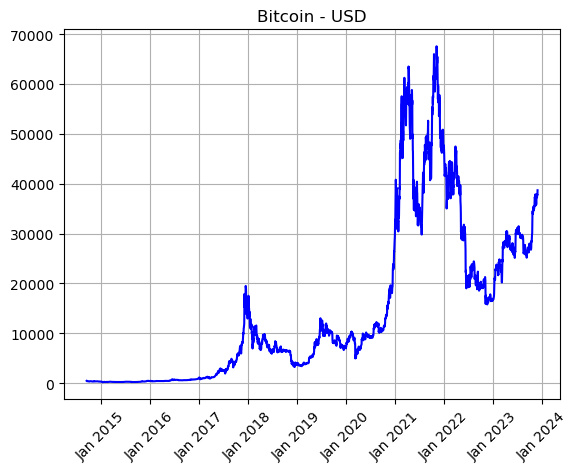

In [23]:
# Plotting the data as a time series index
plt.plot(df_bitcoin['date'], df_bitcoin['data'],color='blue', linestyle='-')

plt.title('Bitcoin - USD')
plt.grid(True)

# Set the date format for x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Specify the frequency of ticks for months
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

plt.show()

# Trends and Seasonality 

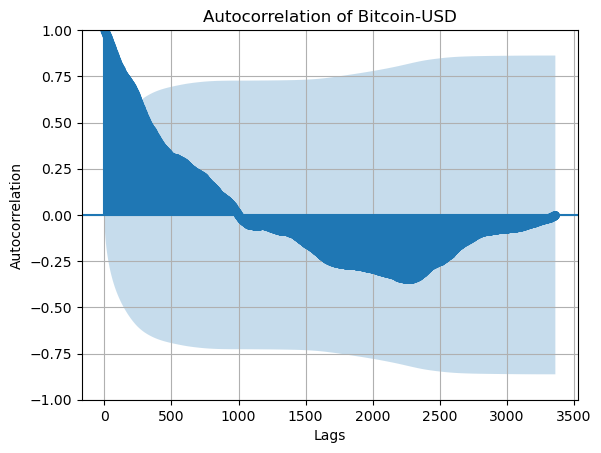

In [24]:
#Autocorrelation (730 lags = 2 years)
plot_acf(x = df_bitcoin['data'], lags= len(df_bitcoin) - 1, alpha=0.05)
plt.title('Autocorrelation of Bitcoin-USD')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

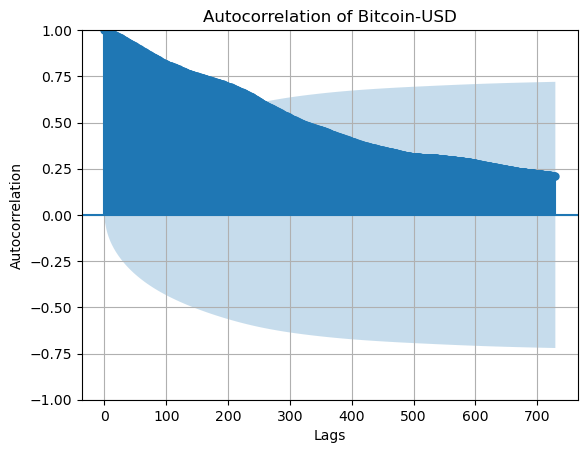

In [25]:
#Autocorrelation (730 lags = 2 years)
plot_acf(x = df_bitcoin['data'], lags= 730 - 1, alpha=0.05)
plt.title('Autocorrelation of Bitcoin-USD')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

In [26]:
acorr = sm.tsa.acf(df_bitcoin['data'], nlags = 730)
#Most important lags 1 (day), 30 (month), 90 (quarter), 365 (year)
print(acorr[0],acorr[1],acorr[30],acorr[90],acorr[365])

1.0 0.9983658900025849 0.9490380104753976 0.83191264503259 0.4392909513750293


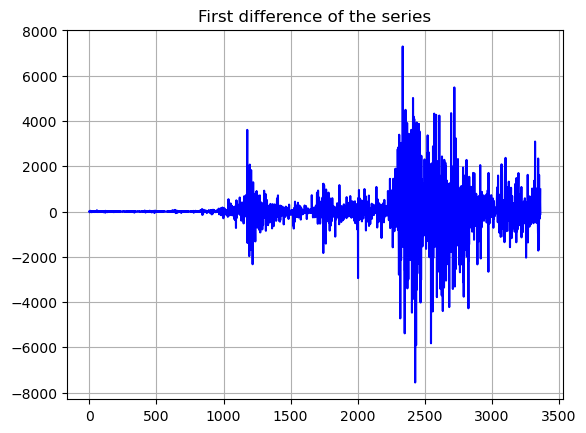

In [27]:
#First difference (as the time series is not stationary)
df_bitcoin_diff = df_bitcoin.copy()
#create column for first difference
df_bitcoin_diff['diff'] = pd.Series.diff(df_bitcoin['data'])
df_bitcoin_diff.fillna(0, inplace=True)

# Plotting differentiated series
plt.plot(df_bitcoin_diff['diff'], color='blue', linestyle='-')

plt.title('First difference of the series')
plt.grid(True)
plt.show()

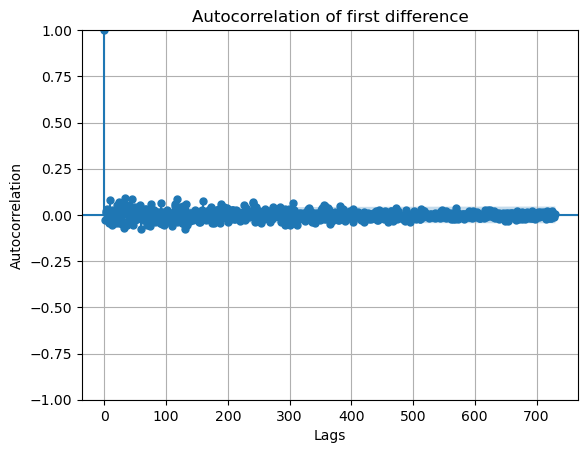

In [28]:
#Autocorrelation of first difference
plot_acf(x = df_bitcoin_diff['diff'], lags=730, alpha=0.05)  # Adjust 'lags' as needed
plt.title('Autocorrelation of first difference')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

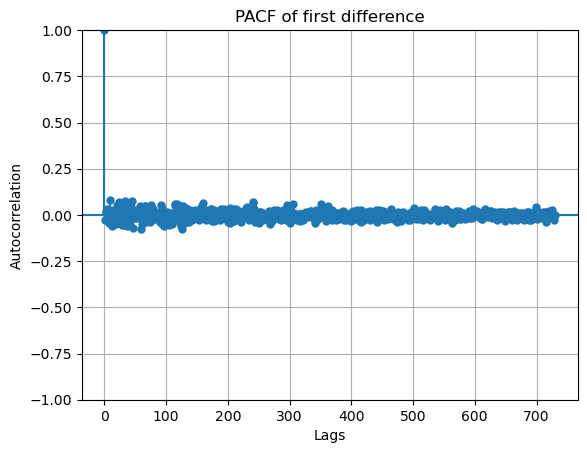

In [29]:
#pacf of the first difference
plot_pacf(x = df_bitcoin_diff['diff'], lags=730, alpha=0.05, method = 'ywm')  # Adjust 'lags' as needed
plt.title('PACF of first difference')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Data prepsocessing

In [30]:
#check for missing values
df_bitcoin.isnull().sum()

date        0
data        0
currency    0
dtype: int64

In [31]:
#convert date to datetime datatype
df_bitcoin['date'] = pd.to_datetime(df_bitcoin['date'])
#add timestamp column
df_bitcoin['timestamp'] = pd.to_datetime(df_bitcoin['date']).astype(np.int64) 
df_bitcoin['timestamp'] = df_bitcoin['timestamp'].div(10**9)
#split date
df_bitcoin['year']  = df_bitcoin['date'].dt.year
df_bitcoin['month']  = df_bitcoin['date'].dt.month
df_bitcoin['day']  = df_bitcoin['date'].dt.day
#add lag 1 column (1 shift)
df_bitcoin['lag_1'] = df_bitcoin['data'].shift(1)
df_bitcoin = df_bitcoin.drop(df_bitcoin.index[0]).reset_index(drop=True)
df_bitcoin.head()

,date,data,currency,timestamp,year,month,day,lag_1
0,2014-09-18,424.440002,BTC-USD,1.410998e+09,2014,9,18,457.334015
1,2014-09-19,394.795990,BTC-USD,1.411085e+09,2014,9,19,424.440002
2,2014-09-20,408.903992,BTC-USD,1.411171e+09,2014,9,20,394.795990
3,2014-09-21,398.821014,BTC-USD,1.411258e+09,2014,9,21,408.903992
4,2014-09-22,402.152008,BTC-USD,1.411344e+09,2014,9,22,398.821014


In [32]:
#split into train and test dataset
train_length = int(len(df_bitcoin) * 0.85)  # 85% for training
# Split into train and test sets last 15% for test of forecasting
train_data = df_bitcoin.iloc[:train_length]
test_data = df_bitcoin.iloc[train_length:]


# AIC Calculation 
check what is the best way to calculate the AIC for gradient boosting 

In [33]:
def get_aic(residuals, num_params):
    # Number of observations
    n = len(residuals)
    # Calculate the residual sum of squares
    RSS = np.sum(residuals**2)
    # Calculate the log-likelihood
    log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(RSS / n) - n / 2
    # Calculate AIC
    aic = -2 * log_likelihood + 2 * num_params
    
    return aic

# ARIMA Model


In [34]:
data = train_data['data'].values

# Define the range of p and q values to search through
p_values = range(0, 7)  # Adjust the range as needed
q_values = range(0, 7)  # Adjust the range as needed

# Initialize variables for best AIC, p, and q
best_aic = float("inf")
best_p = 0
best_q = 0

# Iterate through different combinations of p and q
for p in p_values:
    for q in q_values:
        try:
            # Fit the ARIMA model for each combination of p and q
            model = ARIMA(data, order=(p, 1, q))
            fitted_model = model.fit()

            # Get the AIC value for the fitted model
            current_aic = fitted_model.aic

            # Update best AIC and parameters if current AIC is lower
            if current_aic < best_aic:
                best_aic = current_aic
                best_p = p
                best_q = q

        except:
            continue

print(f"Best AIC: {best_aic}")
print(f"Best p: {best_p}")
print(f"Best q: {best_q}")

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model

Best AIC: 46281.39686476793
Best p: 4
Best q: 6


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


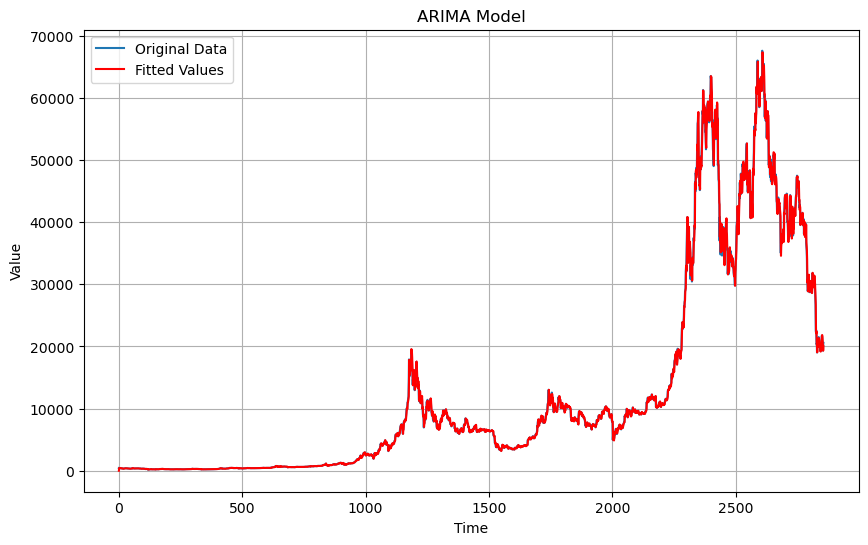

In [35]:
model = ARIMA(data, order=(best_p, 1, best_q))
a1 = model.fit()
# Fitted values
fit1 = a1.fittedvalues

# Plot original data and fitted values
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original Data')
plt.plot(fit1, color='red', label='Fitted Values')
plt.title('ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

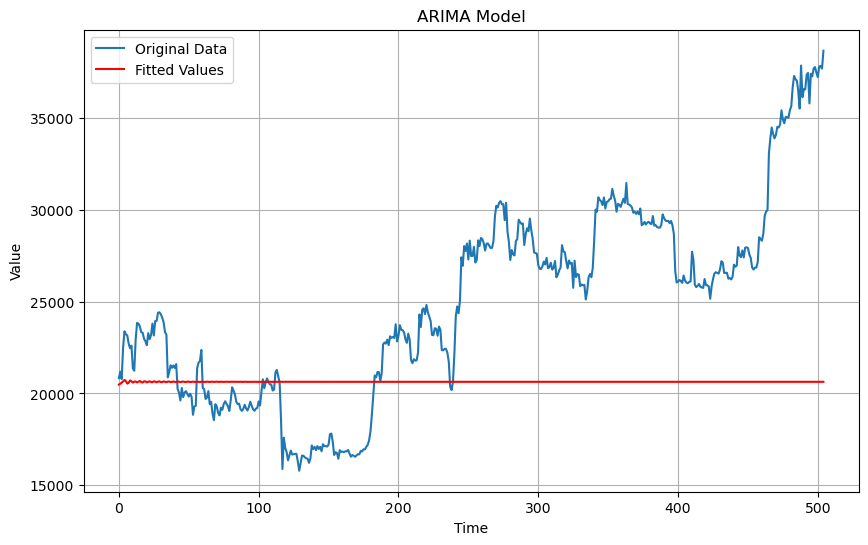

In [36]:
#static forecast
forecast_steps = len(test_data)
forecast = a1.forecast(steps=forecast_steps)

# Plot original data and fitted values
plt.figure(figsize=(10, 6))
plt.plot(test_data['data'].values, label='Original Data')
plt.plot(forecast, color='red', label='Fitted Values')
plt.title('ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

Test RMSE: 610.434


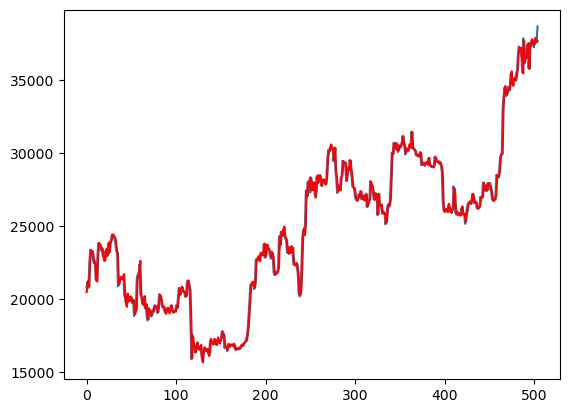

In [37]:
#cell takes long to run
#rolling forecast
#rolling forecast (always just forecast the next value)
predictions = list()
data = data.tolist()
test = test_data['data'].values

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(data, order=(best_p, 1, best_q))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    data.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

    # evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# SARIMA

not working memory issues

In [38]:
#data = train_data['data'].values

# Downsample your data
downsampled_data = data[::2]  

# Define the range of p, d, and q values to search through
p_values = range(0, 5)  # Adjust the range as needed
d_values = range(1,1)  # Adjust the range as needed
q_values = range(0, 5)  # Adjust the range as needed

# Define the range of seasonal P, D, and Q values to search through
P_values = range(0, 5)  # Adjust the range as needed
D_values = range(1,1)  # Adjust the range as needed
Q_values = range(0, 5)  # Adjust the range as needed
seasonal_period = 365  # Adjust according to your seasonality

# Initialize variables for best AIC, parameters (p, d, q, P, D, Q, s)
best_aic = float("inf")
best_params = None

# Iterate through different combinations of p, d, q, P, D, Q
for p in p_values:
    for q in q_values:
        for P in P_values:
            for Q in Q_values:
                # Fit the SARIMA model for each combination of parameters
                model = SARIMAX(downsampled_data, order=(p, 1, q), seasonal_order=(P, 1 , Q, seasonal_period))
                fitted_model = model.fit()

                # Get the AIC value for the fitted model
                current_aic = fitted_model.aic

                            # Update best AIC and parameters if current AIC is lower
                if current_aic < best_aic:
                    best_aic = current_aic
                    best_params = (p, 1, q, P, 1, Q, seasonal_period)

print(f"Best AIC: {best_aic}")
print(f"Best parameters (p, d, q, P, D, Q, s): {best_params}")

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


KeyboardInterrupt: 

# Linear Gam model


In [42]:
# Define your features and target variable
features = ['year', 'month', 'day', 'lag_1']
X_train = train_data[features].values
X_test = test_data[features].values
y_train  = train_data['data'].values
y_test  = test_data['data'].values

In [43]:
# Define the hyperparameters to search over
search_space = {'lam': [0.4,0.6, 0.8], 'n_splines': [4, 6, 10, 20, 50]}  # Adjust as needed

# Define the terms for the GAM model
terms = s(0) + s(1) + s(2) + f(3)

best_aic = float('inf')
best_model = None


for lam, n_splines in product(search_space['lam'], search_space['n_splines']):
    try:
        gam = LinearGAM(terms=terms, lam=lam, n_splines=n_splines)
        gam.fit(X_train, y_train)
        aic = gam.statistics_['AIC']
        if aic < best_aic:
            best_aic = aic
            best_lam = lam
            best_splines = n_splines
            best_model = gam
    except Exception as e:
        print(e)
        print(lam)
        print(n_splines)
# Evaluate on test data

best_gam = best_model

SVD did not converge
0.6
6
SVD did not converge
0.6
50
SVD did not converge
0.8
10


In [44]:
print("Best lam:", best_lam)
print("Best splines:", best_splines)

Best lam: 0.4
Best splines: 50


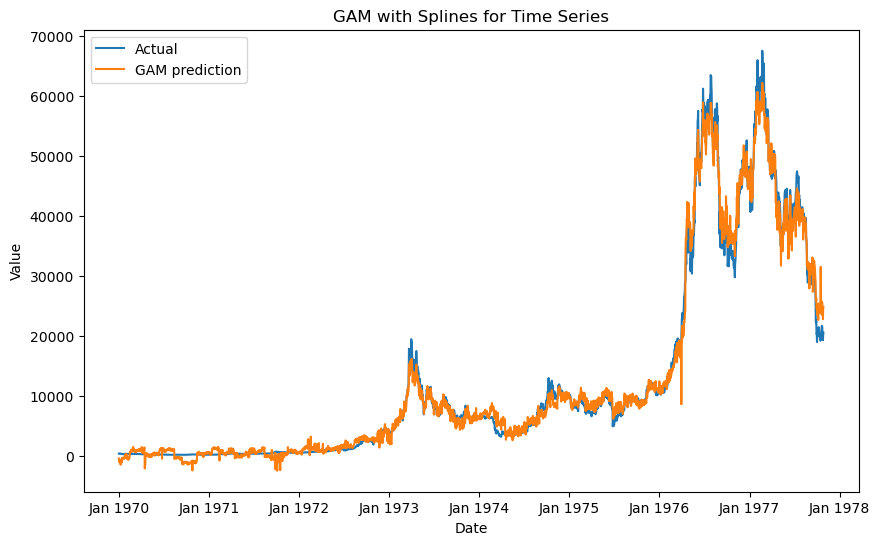

In [45]:
gam = LinearGAM(terms=terms, lam=best_lam, n_splines=best_splines)
gam.fit(X_train, y_train)

predictions = gam.predict(X_train)


#plot the gam model
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(predictions, label='GAM prediction')

# Specify the frequency of ticks for months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('GAM with Splines for Time Series')
plt.show()

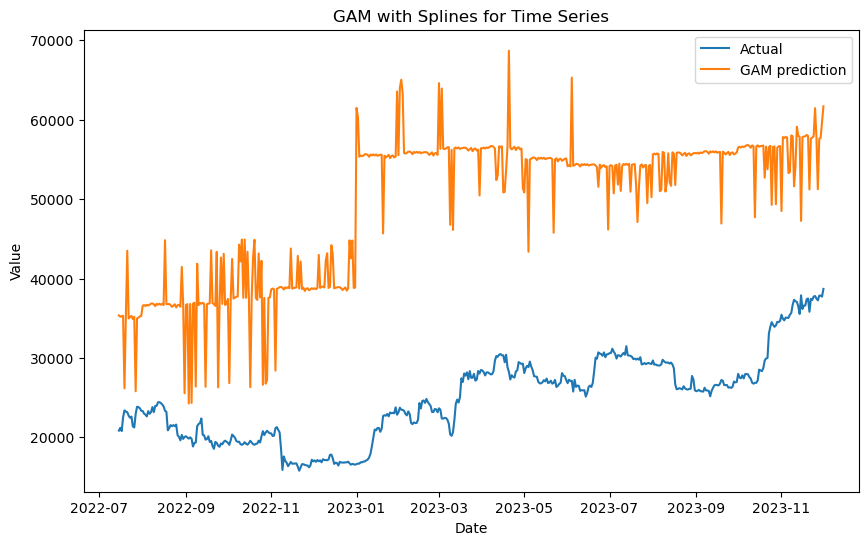

In [46]:
predictions = gam.predict(X_test)

#plot the gam model
plt.figure(figsize=(10, 6))
plt.plot(test_data['date'], y_test, label='Actual')
plt.plot(test_data['date'], predictions, label='GAM prediction')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('GAM with Splines for Time Series')
plt.show()

# Gradient Boosting

In [47]:
# Separate input features and target variable
X_train = train_data[['day', 'month', 'year', 'lag_1']]
X_test = test_data[['day', 'month', 'year', 'lag_1']]
y_train = train_data['data']
y_test = test_data['data']

In [48]:
# Define parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Use 'reg:squarederror' for regression
    'max_depth': 5,
    'eta': 0.2,
    # Add other parameters as needed
}

In [49]:
# Create DMatrix for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the model
model = xgb.train(params, dtrain, num_boost_round=100)

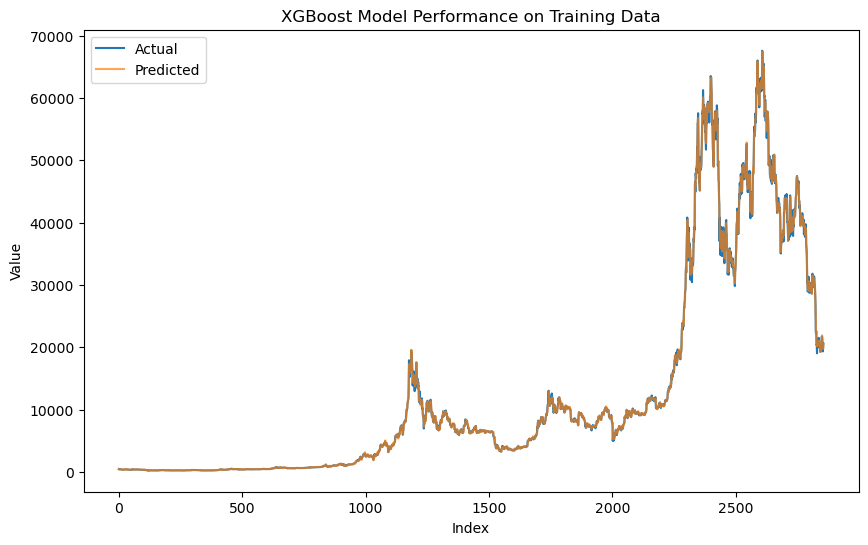

In [50]:
# Make predictions on the test set
train_predictions = model.predict(dtrain)

# Plotting the performance on the training set
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(train_predictions, label='Predicted', alpha=0.7)
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('XGBoost Model Performance on Training Data')
plt.show()

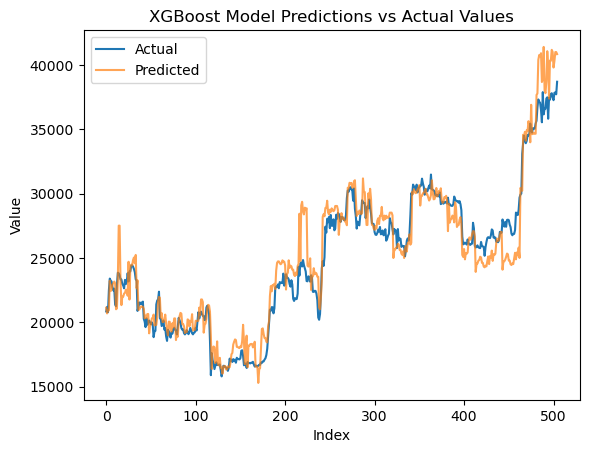

In [51]:
predictions = model.predict(dtest)
y_test = y_test.reset_index(drop=True)
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('XGBoost Model Predictions vs Actual Values')
plt.show()